# How Do We Figure Out What a Star Is Like?

## A Beginner's Guide to Computing Stellar Properties from Survey Data

Stars are very far away. We cannot visit them, weigh them, or stick a thermometer in them. Yet astronomers have figured out the **distance**, **temperature**, **luminosity** (total brightness), and **mass** of hundreds of millions of stars. How?

This notebook walks through the math and physics behind the stellar property pipeline, step by step. We will use real data from the **Gaia DR3** space survey -- the most precise star catalog ever made.

**What you will learn:**
1. How to turn a parallax angle into a distance (and why the naive formula fails)
2. How the color of a star tells you its temperature
3. How to calculate a star's true brightness from its apparent brightness and distance
4. How a star's brightness reveals its mass

**Prerequisites:** Basic algebra and Python. Some comfort with logarithms is helpful but we will explain as we go.

In [3]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Make plots look nice
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 12

---
## Our Test Stars

We will work with two well-known stars:

| Star | What it is | Why it is interesting |
|---|---|---|
| **Proxima Centauri** | A tiny red dwarf (M5.5V) | The nearest star to the Sun (1.3 pc) |
| **Sun** (synthetic) | A G2V dwarf | Our reference point -- we know its properties exactly |

The data below comes from the Gaia DR3 catalog. Each field is something Gaia measured by pointing its telescope at the star.

In [4]:
# Proxima Centauri -- real Gaia DR3 measurements
proxima_cen = {
    "source_id": "5853498713190525696",
    "parallax_mas": 768.07,       # parallax angle in milli-arcseconds
    "parallax_error_mas": 0.03,   # how uncertain that measurement is
    "phot_g_mean_mag": 11.13,     # apparent brightness in Gaia's G band
    "bp_rp": 3.50,               # color: blue brightness minus red brightness
    "ag_gspphot": 0.01,          # how much dust dims the G-band light
    "ebpminrp_gspphot": 0.005,   # how much dust reddens the color
    "feh": 0.0,                  # metallicity (0 = same as Sun)
    "logg": 4.5,                 # surface gravity (tells us if it is a dwarf or giant)
}

# Sun-like star -- synthetic (what the Sun would look like at 10 pc away)
sun_like = {
    "source_id": "sun_synthetic",
    "parallax_mas": 100.0,        # 100 mas = 10 pc
    "parallax_error_mas": 0.01,
    "phot_g_mean_mag": 4.83,      # the Sun's absolute G magnitude
    "bp_rp": 0.82,
    "ag_gspphot": 0.0,
    "ebpminrp_gspphot": 0.0,
    "feh": 0.0,
    "logg": 4.44,
}

print("Data loaded. Let's begin!")

Data loaded. Let's begin!


---
# Part 1: Distance -- How Far Away Is the Star?

## What is parallax?

Hold your thumb up and close one eye, then the other. Your thumb appears to jump against the background. That "jump" is **parallax** -- the apparent shift of a nearby object when viewed from two different positions.

The Gaia satellite does the same trick but uses the Earth's orbit as its baseline. Over six months the Earth moves ~300 million km, and Gaia photographs each star from both sides of the orbit. The tiny angular shift tells us how far away the star is.

The parallax angle is measured in **milliarcseconds** (mas). One arcsecond is 1/3600 of a degree -- incredibly tiny. A star at exactly 1 parsec (3.26 light-years) would have a parallax of 1000 mas.

## The naive approach (and why it breaks)

The textbook formula is:

$$d = \frac{1000}{\pi}$$

where $d$ is distance in parsecs and $\pi$ is parallax in mas. Let's try it:

In [5]:
# Naive distance for Proxima Centauri
parallax = proxima_cen["parallax_mas"]
naive_distance = 1000.0 / parallax
print(f"Proxima Centauri naive distance: {naive_distance:.4f} pc")
print(f"Known distance:                  1.3012 pc")
print(f"Pretty close! But that's because Proxima has very small measurement error.")
print()

# Now imagine a distant star with noisy parallax
print("--- What happens with noisy measurements? ---")
print()
noisy_parallax = 0.5   # mas
noisy_error = 0.3      # mas -- 60% relative error!

# Simulate 10,000 "measurements" drawn from the error distribution
np.random.seed(42)
simulated_parallaxes = np.random.normal(noisy_parallax, noisy_error, 10000)

# Some measurements will be zero or negative!
n_negative = np.sum(simulated_parallaxes <= 0)
print(f"Out of 10,000 simulated measurements:")
print(f"  {n_negative} have zero or negative parallax (cannot invert!)")

# For the positive ones, compute naive distances
positive = simulated_parallaxes[simulated_parallaxes > 0]
naive_distances = 1000.0 / positive
print(f"  Naive distance mean: {np.mean(naive_distances):.0f} pc")
print(f"  Naive distance median: {np.median(naive_distances):.0f} pc")
print(f"  True distance: {1000.0 / 0.5:.0f} pc")
print()
print("The mean is wildly off because 1/x blows up near zero.")
print("This is why we need a smarter approach: Bayesian inference.")

Proxima Centauri naive distance: 1.3020 pc
Known distance:                  1.3012 pc
Pretty close! But that's because Proxima has very small measurement error.

--- What happens with noisy measurements? ---

Out of 10,000 simulated measurements:
  491 have zero or negative parallax (cannot invert!)
  Naive distance mean: 4089 pc
  Naive distance median: 1932 pc
  True distance: 2000 pc

The mean is wildly off because 1/x blows up near zero.
This is why we need a smarter approach: Bayesian inference.


## The Bayesian approach

Instead of directly inverting the parallax, we ask: **given the parallax we measured, what is the probability that the star is at distance $r$?**

Bayes' theorem tells us:

$$P(r \mid \pi_{obs}) \propto P(\pi_{obs} \mid r) \times P(r)$$

In words: **posterior** = **likelihood** x **prior**.

### The likelihood: "If the star were at distance r, how likely is the parallax we measured?"

If a star is truly at distance $r$ parsecs, its true parallax is $1000/r$ mas. But our measurement has Gaussian noise, so:

$$P(\pi_{obs} \mid r) = \text{Normal}\left(\frac{1000}{r},\; \sigma_\pi\right)$$

### The prior: "How likely is it that a star is at distance r, before we look at the data?"

Stars are not uniformly distributed. At greater distances, the volume of space grows as $r^2$, so there are more stars further away. But at very large distances, we run out of Galaxy. A standard prior (Bailer-Jones 2015) combines these effects:

$$P(r) \propto r^2 \exp\left(-\frac{r}{L}\right)$$

where $L = 1350$ pc is a scale length that represents the typical extent of the Galaxy in any direction.

### Putting it together

We multiply prior and likelihood at every possible distance, then find the peak (our best estimate) and the spread (our uncertainty).

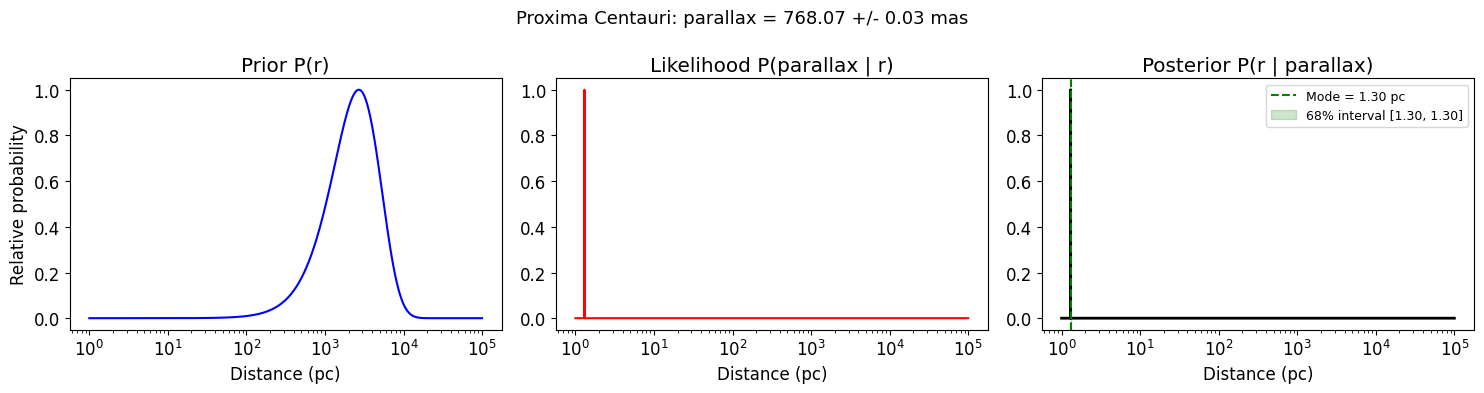

Proxima Centauri: 1.3017 pc [1.3004, 1.3015]
Known value:      1.3012 pc



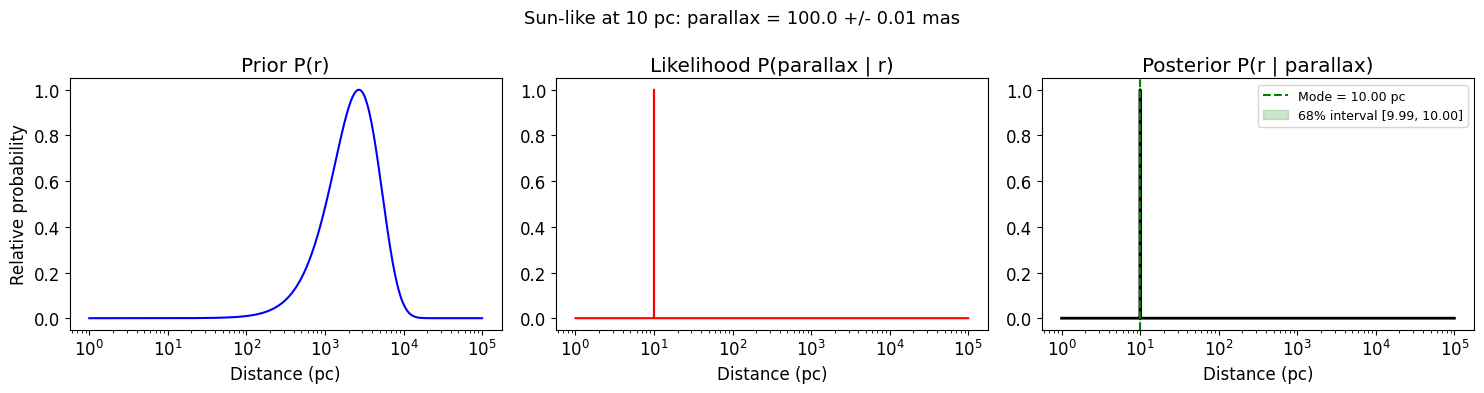

Sun-like star:    10.0023 pc [9.9926, 10.0005]
True value:       10.0 pc


In [6]:
def bayesian_distance(parallax_mas, parallax_error_mas, label="Star"):
    """
    Compute distance using Bayesian parallax inversion.
    Returns (mode, lower_16, upper_84) in parsecs.
    """
    # Step 0: Apply the Gaia zero-point correction.
    # Gaia DR3 has a known bias: all parallaxes are ~0.017 mas too small.
    parallax_corrected = parallax_mas + 0.017

    # Step 1: Create a grid of candidate distances.
    # We use log-spacing so we have fine resolution at small distances
    # and coarser resolution at large distances (where we care less about precision).
    r = np.logspace(np.log10(1), np.log10(100_000), 10_000)  # 1 pc to 100,000 pc

    # Step 2: Compute the prior at each grid point.
    L = 1350.0  # scale length in parsecs
    prior = r**2 * np.exp(-r / L)

    # Step 3: Compute the likelihood at each grid point.
    # "If the star is at distance r, its true parallax is 1000/r.
    #  How consistent is that with what we actually measured?"
    predicted_parallax = 1000.0 / r
    likelihood = norm.pdf(parallax_corrected, loc=predicted_parallax, scale=parallax_error_mas)

    # Step 4: Posterior = prior * likelihood
    posterior = prior * likelihood

    # Step 5: Normalize so it sums to 1 (a proper probability distribution)
    posterior /= np.trapezoid(posterior, r)

    # Step 6: Find the mode (peak) -- our best distance estimate
    mode_idx = np.argmax(posterior)
    distance_pc = r[mode_idx]

    # Step 7: Find the 16th and 84th percentiles (like +/- 1 sigma)
    cdf = np.cumsum(posterior * np.gradient(r))
    cdf /= cdf[-1]
    lower = np.interp(0.16, cdf, r)
    upper = np.interp(0.84, cdf, r)

    # --- Plot ---
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Prior
    axes[0].plot(r, prior / np.max(prior), 'b-')
    axes[0].set_title('Prior P(r)')
    axes[0].set_xlabel('Distance (pc)')
    axes[0].set_ylabel('Relative probability')
    axes[0].set_xscale('log')

    # Likelihood
    axes[1].plot(r, likelihood / np.max(likelihood), 'r-')
    axes[1].set_title('Likelihood P(parallax | r)')
    axes[1].set_xlabel('Distance (pc)')
    axes[1].set_xscale('log')

    # Posterior
    axes[2].plot(r, posterior / np.max(posterior), 'k-', linewidth=2)
    axes[2].axvline(distance_pc, color='green', linestyle='--', label=f'Mode = {distance_pc:.2f} pc')
    axes[2].axvspan(lower, upper, alpha=0.2, color='green', label=f'68% interval [{lower:.2f}, {upper:.2f}]')
    axes[2].set_title('Posterior P(r | parallax)')
    axes[2].set_xlabel('Distance (pc)')
    axes[2].set_xscale('log')
    axes[2].legend(fontsize=9)

    fig.suptitle(f'{label}: parallax = {parallax_mas} +/- {parallax_error_mas} mas', fontsize=13)
    plt.tight_layout()
    plt.show()

    return distance_pc, lower, upper


# Run it on our two stars
print("=" * 60)
d, lo, hi = bayesian_distance(768.07, 0.03, "Proxima Centauri")
print(f"Proxima Centauri: {d:.4f} pc [{lo:.4f}, {hi:.4f}]")
print(f"Known value:      1.3012 pc")
print()

d, lo, hi = bayesian_distance(100.0, 0.01, "Sun-like at 10 pc")
print(f"Sun-like star:    {d:.4f} pc [{lo:.4f}, {hi:.4f}]")
print(f"True value:       10.0 pc")

### What did we just see?

Look at the three panels:

1. **Prior (blue):** Before looking at the data, the prior says "most stars are around 1000-2000 pc away" because that's where the most volume is. It knows nothing about this particular star.

2. **Likelihood (red):** The measurement says the parallax is very large (768 mas for Proxima), which means the star must be very close. The likelihood is a sharp spike near 1.3 pc.

3. **Posterior (black):** The product of the two. For Proxima Centauri, the measurement is so precise that the likelihood completely dominates -- the posterior is nearly identical to the likelihood. The prior barely matters.

For noisier measurements, the prior pulls the posterior away from the naive estimate, which is the whole point of the Bayesian approach.

### Demo: when the prior matters

Let's see what happens with a noisy parallax where the Bayesian approach makes a real difference:

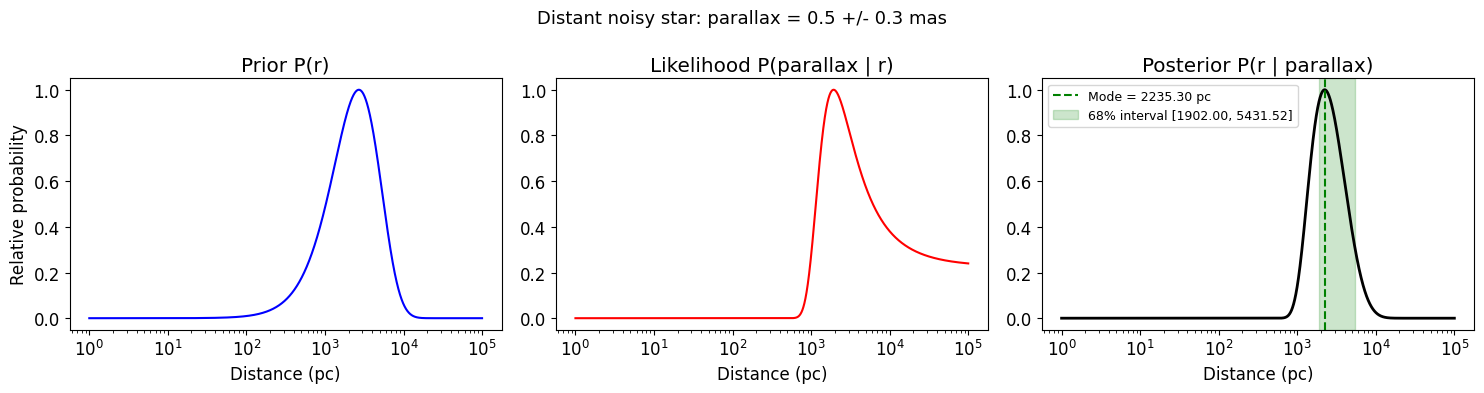

Bayesian distance: 2235 pc [1902, 5432]
Naive  distance:   2000 pc

Notice how the posterior is broader and shifted -- the prior is doing real work here.


In [7]:
# A distant star with noisy parallax
d, lo, hi = bayesian_distance(0.5, 0.3, "Distant noisy star")
print(f"Bayesian distance: {d:.0f} pc [{lo:.0f}, {hi:.0f}]")
print(f"Naive  distance:   {1000/0.5:.0f} pc")
print()
print("Notice how the posterior is broader and shifted -- the prior is doing real work here.")

## Bonus: Cepheid variable stars (a "standard candle")

For a special type of pulsating star called a **Cepheid**, we have a second way to measure distance that works even when parallax is too noisy.

In 1912, Henrietta Leavitt discovered that brighter Cepheids pulsate more slowly. If you measure the pulsation period (easy -- just watch the star over a few days), you can calculate its **absolute brightness**. Comparing that to its **apparent brightness** gives the distance.

$$M_V = -2.43 \log_{10}(P) - 4.05$$

$$d = 10^{(G_0 - M_V + 5) / 5}$$

where $P$ is the pulsation period in days, $M_V$ is the absolute magnitude, and $G_0$ is the extinction-corrected apparent magnitude.

In [8]:
# Delta Cephei -- the prototype Cepheid variable star
period_days = 5.37
phot_g_mean_mag = 3.95
ag_gspphot = 0.25  # dust extinction

# Step 1: Absolute magnitude from the Leavitt Law
M_V = -2.43 * np.log10(period_days) - 4.05
print(f"Step 1: Absolute magnitude M_V = -2.43 * log10({period_days}) - 4.05 = {M_V:.3f}")

# Step 2: Correct apparent magnitude for dust
G_0 = phot_g_mean_mag - ag_gspphot
print(f"Step 2: Corrected apparent mag G_0 = {phot_g_mean_mag} - {ag_gspphot} = {G_0:.2f}")

# Step 3: Distance from the distance modulus formula
distance_pc = 10 ** ((G_0 - M_V + 5) / 5)
print(f"Step 3: Distance = 10^(({G_0:.2f} - ({M_V:.3f}) + 5) / 5) = {distance_pc:.0f} pc")
print()
print(f"Note: The accepted distance for Delta Cephei is ~270 pc.")
print(f"Our estimate is {distance_pc:.0f} pc because we used G-band as a proxy for V-band,")
print(f"which introduces a systematic offset. A color correction would fix this.")

Step 1: Absolute magnitude M_V = -2.43 * log10(5.37) - 4.05 = -5.824
Step 2: Corrected apparent mag G_0 = 3.95 - 0.25 = 3.70
Step 3: Distance = 10^((3.70 - (-5.824) + 5) / 5) = 803 pc

Note: The accepted distance for Delta Cephei is ~270 pc.
Our estimate is 803 pc because we used G-band as a proxy for V-band,
which introduces a systematic offset. A color correction would fix this.


---
# Part 2: Temperature -- What Color Is the Star?

## The key idea: hotter stars are bluer, cooler stars are redder

This is the same physics as heating a piece of metal: first it glows red, then orange, then white-hot, then blue-white. Stars work the same way.

Gaia measures each star's brightness in three color bands:
- **BP** (Blue Photometer): blue light
- **RP** (Red Photometer): red light
- **G**: broad white light

The **color index** `BP - RP` tells us the ratio of blue to red light:
- **Small or negative BP-RP** = more blue light = hot star (like Sirius, ~10,000 K)
- **Large BP-RP** = more red light = cool star (like Proxima Centauri, ~3,000 K)

## Step 1: Remove the effect of interstellar dust (dereddening)

Dust between us and the star absorbs blue light more than red, making stars look redder and dimmer than they really are. Gaia estimates this reddening for each star. We subtract it:

In [9]:
def deredden(star):
    """Remove the effect of interstellar dust."""
    # Corrected color: remove reddening
    bp_rp_0 = star["bp_rp"] - star.get("ebpminrp_gspphot", 0.0)

    # Corrected brightness: remove dimming
    G_0 = star["phot_g_mean_mag"] - star.get("ag_gspphot", 0.0)

    return bp_rp_0, G_0


bp_rp_0_prox, G_0_prox = deredden(proxima_cen)
bp_rp_0_sun, G_0_sun = deredden(sun_like)

print(f"Proxima Centauri: (BP-RP)_0 = {bp_rp_0_prox:.3f}  (very red -- cool star)")
print(f"Sun-like star:    (BP-RP)_0 = {bp_rp_0_sun:.3f}  (moderate -- yellow star)")

Proxima Centauri: (BP-RP)_0 = 3.495  (very red -- cool star)
Sun-like star:    (BP-RP)_0 = 0.820  (moderate -- yellow star)


## Step 2: Convert color to temperature

Astronomers have measured the temperatures of many stars independently (using spectroscopy) and fit a polynomial that converts the Gaia color index to temperature.

The formula (from Mucciarelli, Bellazzini & Massari 2021) is:

$$\theta = b_0 + b_1 C + b_2 C^2 + b_3 [\text{Fe/H}] + b_4 [\text{Fe/H}]^2 + b_5 [\text{Fe/H}] \cdot C$$

$$T_{\text{eff}} = \frac{5040}{\theta}$$

where:
- $C$ = the dereddened color (BP-RP)$_0$
- [Fe/H] = metallicity (how many heavy elements the star has, compared to the Sun)
- $b_0$ through $b_5$ = calibration coefficients that differ for **dwarf** vs **giant** stars

The number 5040 comes from the relationship between a star's surface temperature and its spectrum.

Different coefficients are used for dwarfs (logg >= 3.0) and giants (logg < 3.0) because they have different atmospheric structures that affect their colors.

In [10]:
# Polynomial coefficients from Mucciarelli et al. (2021)
DWARF_B = [0.4929, 0.5092, -0.0353, 0.0192, -0.0020, -0.0395]
DWARF_COLOR_RANGE = (0.39, 1.50)  # valid range for the polynomial

GIANT_B = [0.5323, 0.4775, -0.0344, -0.0110, -0.0020, -0.0009]
GIANT_COLOR_RANGE = (0.33, 1.81)


def compute_teff(bp_rp_0, feh, logg):
    """
    Convert dereddened color to effective temperature.

    bp_rp_0: dereddened (BP-RP) color
    feh: [Fe/H] metallicity (0 = solar)
    logg: surface gravity (>= 3.0 for dwarfs)
    """
    is_dwarf = logg >= 3.0
    b = DWARF_B if is_dwarf else GIANT_B
    color_range = DWARF_COLOR_RANGE if is_dwarf else GIANT_COLOR_RANGE

    # Check if color is in the valid range for the polynomial
    flag = "ok"
    if bp_rp_0 < color_range[0] or bp_rp_0 > color_range[1]:
        flag = "outside_valid_range"

    C = bp_rp_0
    theta = (b[0]
             + b[1] * C
             + b[2] * C**2
             + b[3] * feh
             + b[4] * feh**2
             + b[5] * feh * C)

    teff = 5040.0 / theta
    dispersion = 61 if is_dwarf else 83  # calibration uncertainty in K

    return teff, dispersion, flag


# Compute Teff for our stars
teff_sun, disp_sun, flag_sun = compute_teff(bp_rp_0_sun, feh=0.0, logg=4.44)
teff_prox, disp_prox, flag_prox = compute_teff(bp_rp_0_prox, feh=0.0, logg=4.5)

print(f"Sun-like star:    Teff = {teff_sun:.0f} +/- {disp_sun} K  (flag: {flag_sun})")
print(f"  Expected: ~5772 K")
print()
print(f"Proxima Centauri: Teff = {teff_prox:.0f} +/- {disp_prox} K  (flag: {flag_prox})")
print(f"  Expected: ~3042 K")
print(f"  Note: (BP-RP)_0 = {bp_rp_0_prox:.2f} is far outside the valid range {DWARF_COLOR_RANGE}.")
print(f"  The polynomial was not calibrated for such red stars, so the result is unreliable.")

Sun-like star:    Teff = 5684 +/- 61 K  (flag: ok)
  Expected: ~5772 K

Proxima Centauri: Teff = 2737 +/- 61 K  (flag: outside_valid_range)
  Expected: ~3042 K
  Note: (BP-RP)_0 = 3.50 is far outside the valid range (0.39, 1.5).
  The polynomial was not calibrated for such red stars, so the result is unreliable.


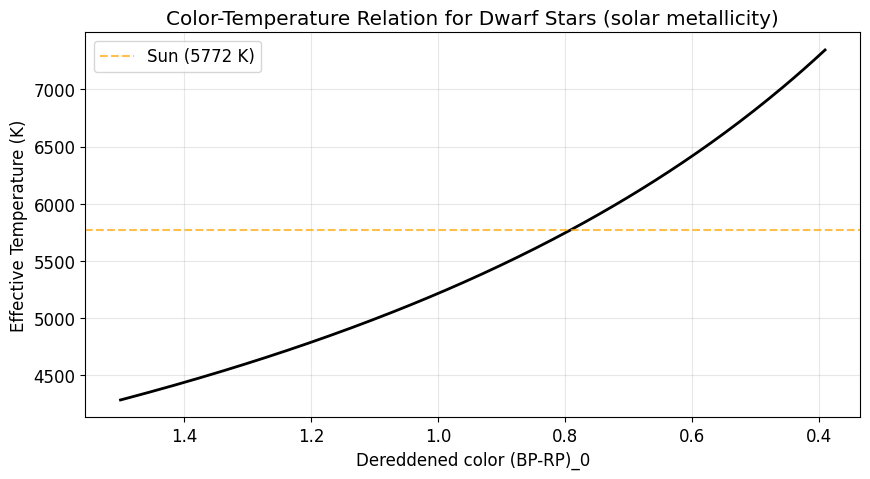

Bluer stars (left) are hotter. Redder stars (right) are cooler.
This is the foundation of stellar classification.


In [11]:
# Visualize: how color maps to temperature
colors = np.linspace(0.39, 1.50, 200)
temps = [5040.0 / (DWARF_B[0] + DWARF_B[1]*c + DWARF_B[2]*c**2) for c in colors]

plt.figure(figsize=(10, 5))
plt.plot(colors, temps, 'k-', linewidth=2)
plt.axhline(5772, color='orange', linestyle='--', alpha=0.7, label='Sun (5772 K)')
plt.xlabel('Dereddened color (BP-RP)_0')
plt.ylabel('Effective Temperature (K)')
plt.title('Color-Temperature Relation for Dwarf Stars (solar metallicity)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()  # convention: hot (blue) stars on the left
plt.show()

print("Bluer stars (left) are hotter. Redder stars (right) are cooler.")
print("This is the foundation of stellar classification.")

## Step 3: Luminosity -- How Bright Is the Star Really?

A flashlight looks bright up close and dim far away, even though it is emitting the same amount of light. Stars are the same. The **apparent magnitude** we see depends on both the star's true brightness and its distance.

Now that we know the distance, we can undo this effect to find the **absolute magnitude** $M_G$ -- how bright the star would look from a standard distance of 10 parsecs:

$$M_G = G_0 - 5 \log_{10}(d) + 5$$

Then we need a **bolometric correction** $BC_G$ to account for light outside Gaia's G filter (infrared, ultraviolet):

$$M_{bol} = M_G + BC_G$$

Finally, we convert to luminosity in solar units:

$$\frac{L}{L_\odot} = 10^{(4.74 - M_{bol}) / 2.5}$$

where 4.74 is the Sun's bolometric absolute magnitude.

In [12]:
def compute_bc_g(teff):
    """
    Bolometric correction for Gaia G-band.
    Source: Andrae et al. (2018)

    This correction accounts for all the light the G filter misses.
    Hot stars emit a lot of UV (large correction).
    Cool stars emit a lot of infrared (large correction).
    Sun-like stars are near the sweet spot (small correction).
    """
    dt = teff - 5772.0  # deviation from solar temperature

    if 4000 <= teff <= 8000:
        # Warm/hot stars
        a = [6.000e-02, 6.731e-05, -6.647e-08, 2.859e-11, -7.197e-15]
    elif 3300 <= teff < 4000:
        # Cool stars
        a = [1.749e+00, 1.977e-03, 3.737e-07, -8.966e-11, -4.183e-14]
    else:
        return None  # outside calibrated range

    bc = a[0] + a[1]*dt + a[2]*dt**2 + a[3]*dt**3 + a[4]*dt**4
    return bc


def compute_luminosity(G_0, distance_pc, teff):
    """Full luminosity calculation, step by step."""
    print(f"  Distance: {distance_pc:.4f} pc")

    # Absolute magnitude
    M_G = G_0 - 5.0 * np.log10(distance_pc) + 5.0
    print(f"  Absolute magnitude M_G = {G_0:.2f} - 5*log10({distance_pc:.2f}) + 5 = {M_G:.3f}")

    # Bolometric correction
    bc = compute_bc_g(teff)
    if bc is None:
        print(f"  Teff = {teff:.0f} K is outside the BC_G range [3300, 8000] K.")
        print(f"  Cannot compute luminosity.")
        return None, M_G, None

    print(f"  Bolometric correction BC_G = {bc:.4f}")

    # Bolometric magnitude
    M_bol = M_G + bc
    print(f"  Bolometric magnitude M_bol = {M_G:.3f} + {bc:.4f} = {M_bol:.3f}")

    # Luminosity
    M_bol_sun = 4.74
    luminosity = 10 ** ((M_bol_sun - M_bol) / 2.5)
    print(f"  Luminosity = 10^((4.74 - {M_bol:.3f}) / 2.5) = {luminosity:.5f} L_sun")

    return luminosity, M_G, bc


# Sun-like star at 10 pc
print("=== Sun-like star ===")
d_sun = 10.0  # we computed this earlier
L_sun, M_G_sun, bc_sun = compute_luminosity(G_0_sun, d_sun, teff_sun)
print(f"  Expected: ~1.0 L_sun")
print()

# Proxima Centauri
print("=== Proxima Centauri ===")
d_prox = 1.3  # approximately
L_prox, M_G_prox, bc_prox = compute_luminosity(G_0_prox, d_prox, teff_prox)
if L_prox is not None:
    print(f"  Expected: ~0.0017 L_sun")
else:
    print(f"  Proxima's Teff ({teff_prox:.0f} K) is outside the BC_G calibration range.")
    print(f"  In the real pipeline, stars this cool would need a different BC calibration.")

=== Sun-like star ===
  Distance: 10.0000 pc
  Absolute magnitude M_G = 4.83 - 5*log10(10.00) + 5 = 4.830
  Bolometric correction BC_G = 0.0535
  Bolometric magnitude M_bol = 4.830 + 0.0535 = 4.884
  Luminosity = 10^((4.74 - 4.884) / 2.5) = 0.87616 L_sun
  Expected: ~1.0 L_sun

=== Proxima Centauri ===
  Distance: 1.3000 pc
  Absolute magnitude M_G = 11.12 - 5*log10(1.30) + 5 = 15.550
  Teff = 2737 K is outside the BC_G range [3300, 8000] K.
  Cannot compute luminosity.
  Proxima's Teff (2737 K) is outside the BC_G calibration range.
  In the real pipeline, stars this cool would need a different BC calibration.


---
# Part 3: Mass -- How Heavy Is the Star?

## The mass-luminosity relation

For main-sequence stars (those that are still "burning" hydrogen in their cores, which is most stars), there is a tight relationship between mass and luminosity:

$$L \propto M^\alpha$$

In other words, **heavier stars are dramatically brighter**. The exponent $\alpha$ varies with mass:

| Luminosity range | $\alpha$ | Physical regime |
|---|---|---|
| L < 0.033 L$_\odot$ | 2.3 | Low-mass red dwarfs: partially convective, less efficient fusion |
| 0.033 - 16 L$_\odot$ | 4.0 | Sun-like stars: this is the classic "L ~ M^4" rule |
| 16 - 54,000 L$_\odot$ | 3.5 | Massive stars: radiation pressure starts to matter |
| > 54,000 L$_\odot$ | 1.0 | Very massive stars: almost entirely radiation-dominated |

Inverting the relation:

$$M = L^{1/\alpha}$$

Why does this work? More massive stars have stronger gravity compressing their cores, which makes the core hotter, which makes nuclear fusion run much faster. The relationship is steep: a star twice the Sun's mass is not twice as bright -- it is **~16 times** as bright ($2^4 = 16$).

In [13]:
def compute_mass(luminosity, teff, logg):
    """
    Estimate mass from luminosity using the piecewise mass-luminosity relation.
    Only valid for main-sequence stars.
    """
    # Main-sequence check: dwarf gravity + temperature in calibrated range
    is_ms = (logg >= 3.5) and (3300 <= teff <= 8000)

    if not is_ms:
        print(f"  NOT main-sequence (logg={logg:.1f}, Teff={teff:.0f} K).")
        print(f"  The mass-luminosity relation does not apply to giants or")
        print(f"  stars outside the calibrated temperature range.")
        return None

    if luminosity is None:
        print(f"  No luminosity available; cannot estimate mass.")
        return None

    # Select the appropriate power-law exponent
    L = luminosity
    if L < 0.033:
        alpha = 2.3
        regime = "low-mass red dwarf"
    elif L < 16:
        alpha = 4.0
        regime = "Sun-like"
    elif L < 54000:
        alpha = 3.5
        regime = "massive star"
    else:
        alpha = 1.0
        regime = "very massive / radiation-dominated"

    mass = L ** (1.0 / alpha)

    print(f"  L = {L:.5f} L_sun -> regime: {regime} (alpha = {alpha})")
    print(f"  M = {L:.5f}^(1/{alpha}) = {mass:.3f} M_sun")

    return mass


# Sun-like star
print("=== Sun-like star ===")
if L_sun is not None:
    mass_sun = compute_mass(L_sun, teff_sun, logg=4.44)
    print(f"  Expected: 1.0 M_sun")
print()

# Proxima Centauri
print("=== Proxima Centauri ===")
mass_prox = compute_mass(L_prox, teff_prox, logg=4.5)
if mass_prox:
    print(f"  Expected: ~0.12 M_sun")

=== Sun-like star ===
  L = 0.87616 L_sun -> regime: Sun-like (alpha = 4.0)
  M = 0.87616^(1/4.0) = 0.967 M_sun
  Expected: 1.0 M_sun

=== Proxima Centauri ===
  NOT main-sequence (logg=4.5, Teff=2737 K).
  The mass-luminosity relation does not apply to giants or
  stars outside the calibrated temperature range.


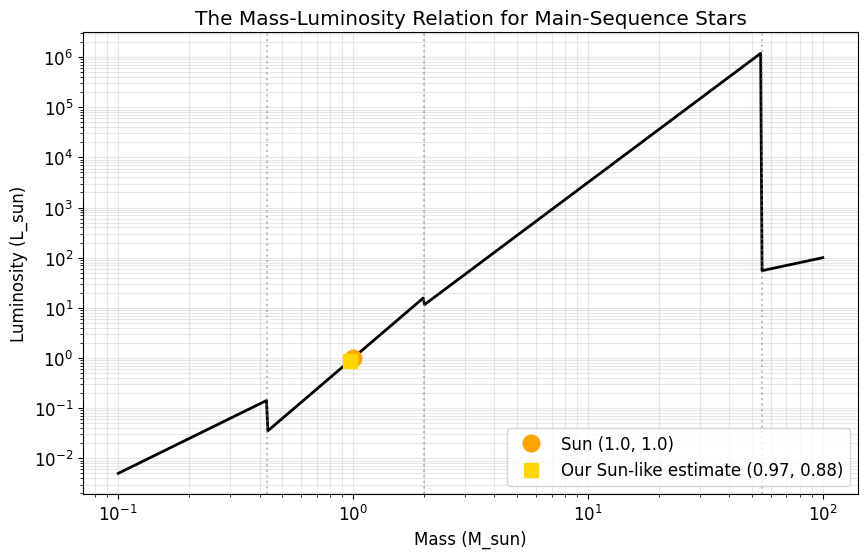

Key insight: a small change in mass means a HUGE change in luminosity.
A 2 M_sun star is 16x brighter than the Sun (2^4 = 16).
A 10 M_sun star is ~3,000x brighter (10^3.5).


In [14]:
# Visualize the mass-luminosity relation
masses = np.logspace(-1, 2, 500)  # 0.1 to 100 solar masses

def mass_to_luminosity(M):
    """Forward direction: mass -> luminosity."""
    if M < 0.43:
        return M ** 2.3
    elif M < 2:
        return M ** 4.0
    elif M < 55:
        return M ** 3.5
    else:
        return M ** 1.0

luminosities = [mass_to_luminosity(m) for m in masses]

plt.figure(figsize=(10, 6))
plt.loglog(masses, luminosities, 'k-', linewidth=2)

# Mark our stars
plt.plot(1.0, 1.0, 'o', color='orange', markersize=12, label='Sun (1.0, 1.0)', zorder=5)
if L_sun is not None and mass_sun is not None:
    plt.plot(mass_sun, L_sun, 's', color='gold', markersize=10,
             label=f'Our Sun-like estimate ({mass_sun:.2f}, {L_sun:.2f})', zorder=5)

# Mark the piecewise boundaries
for m_boundary, label in [(0.43, 'M=0.43'), (2.0, 'M=2'), (55, 'M=55')]:
    l = mass_to_luminosity(m_boundary)
    plt.axvline(m_boundary, color='gray', linestyle=':', alpha=0.5)

plt.xlabel('Mass (M_sun)')
plt.ylabel('Luminosity (L_sun)')
plt.title('The Mass-Luminosity Relation for Main-Sequence Stars')
plt.legend()
plt.grid(True, alpha=0.3, which='both')
plt.show()

print("Key insight: a small change in mass means a HUGE change in luminosity.")
print("A 2 M_sun star is 16x brighter than the Sun (2^4 = 16).")
print("A 10 M_sun star is ~3,000x brighter (10^3.5).")

---
# Putting It All Together: The Full Pipeline

Now let's run the complete pipeline from the `src/` module on our test stars and see the full output.

In [15]:
import json
import sys
sys.path.insert(0, '.')  # so we can import from src/

from src.pipeline import process_star

# Full pipeline on the Sun-like star
sun_input = {
    "source_id": "sun_synthetic",
    "parallax_mas": 100.0,
    "parallax_error_mas": 0.01,
    "phot_g_mean_mag": 4.83,
    "phot_bp_mean_mag": 5.24,
    "phot_rp_mean_mag": 4.42,
    "bp_rp": 0.82,
    "ag_gspphot": 0.0,
    "ebpminrp_gspphot": 0.0,
    "feh": 0.0,
    "logg": 4.44,
    "is_cepheid": False,
    "cepheid_period_days": None,
    "teff_gspphot": 5772.0,
    "lum_gspphot": 1.0,
}

result = process_star(sun_input)
print("=== Pipeline Output for Sun-like star ===")
print(json.dumps(result, indent=2))
print()
print("Expected values:  distance ~10 pc, Teff ~5772 K, L ~1.0 Lsun, M ~1.0 Msun")

2026-02-13 15:11:44,211 [src.pipeline] INFO: Processing star sun_synthetic
2026-02-13 15:11:44,213 [src.distance] INFO: Bayesian distance: parallax_corr=100.017 mas, d=10.002 pc [9.993, 10.000]
2026-02-13 15:11:44,214 [src.temperature] INFO: Luminosity validation ratio: 0.877
2026-02-13 15:11:44,214 [src.temperature] INFO: Teff=5684 K, M_G=4.829, BC_G=0.0535, L=0.87657 Lsun
2026-02-13 15:11:44,215 [src.mass] INFO: Mass estimate: L=0.8766 Lsun, alpha=4.0, M=0.968 Msun
2026-02-13 15:11:44,215 [src.pipeline] INFO: Finished star sun_synthetic


=== Pipeline Output for Sun-like star ===
{
  "source_id": "sun_synthetic",
  "distance_pc": 10.002303080542816,
  "distance_lower_pc": 9.992634595706958,
  "distance_upper_pc": 10.000461464383605,
  "distance_method": "parallax_bayesian",
  "bp_rp_0": 0.82,
  "teff_K": 5683.94376558658,
  "teff_uncertainty_K": 61,
  "teff_flag": "ok",
  "M_G": 4.829499949995,
  "BC_G": 0.0535375797363369,
  "M_bol": 4.883037529731337,
  "luminosity_Lsun": 0.8765667402514375,
  "luminosity_validation_ratio": 0.8765667402514375,
  "mass_Msun": 0.9676008629800456,
  "mass_flag": "ok",
  "is_main_sequence": true
}

Expected values:  distance ~10 pc, Teff ~5772 K, L ~1.0 Lsun, M ~1.0 Msun


---
# Summary: From Photons to Physics

Here's what we did, and why each step matters:

```
Gaia observes a star
        |
        v
  [Parallax angle]  ------>  Module 1: DISTANCE
        |                    (Bayesian inference or Cepheid period-luminosity)
        v
  [Color BP-RP]     ------>  Module 2: TEMPERATURE + LUMINOSITY
  + distance                 (Color-Teff polynomial + distance modulus)
        |
        v
  [Luminosity]      ------>  Module 3: MASS
                             (Mass-luminosity relation)
```

**Key takeaways:**

1. **Distance is the foundation.** Without it, we cannot convert apparent brightness to true brightness (luminosity). The Bayesian approach handles noisy measurements gracefully.

2. **Color encodes temperature.** Hotter stars emit more blue light; cooler stars emit more red. A calibrated polynomial converts the color ratio to Kelvin.

3. **Luminosity bridges to mass.** For main-sequence stars, luminosity and mass are tightly linked by nuclear physics: more mass = hotter core = much more energy output.

4. **Every step has caveats.** Dust corrections, polynomial extrapolation limits, the G-vs-V approximation for Cepheids, and the main-sequence requirement for mass. Real astrophysics is full of "this works, but only within these bounds."

**Want to go further?** Try querying real stars from the Gaia archive using the `src/data_access.py` module and running them through the pipeline!